<a href="https://www.kaggle.com/code/sebastinconcha/farmacias-por-comunas-chile?scriptVersionId=173776936" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datos-farmacias/data_farmacias.json
/kaggle/input/chile-demogrfico-por-comuna/chiledemografico_por_comuna.csv


In [2]:
'''
A partir de tablas de datos públicos otorgados por el gobierno de chile, se genera un reporte estadístico de la cantidad,localizacion y distribución 
de farmacias a lo largo de las comunas de Chile. La informacíón obtenida de las farmacias seencuentra actualizada a 24 de marzo del 2024, pero debido 
a que el último censo realizado por el gobierno es del año 2017,se considerarán las estadísticas demográficas del año 2017.

Beginning with the public datasets granted by the Chilean Government, a statistical report is created based on the quantity, localization and
distribution of pharmacies throughout the communes of Chile. The information about pharmacies is actually updated to march 2024, but due to the last
census carried out in chile was in 2017, the demographic information is updated as year 2017.
'''

#importamos librerias a usar / import of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
'''
Seteamos configuracion de pandas, obtenemos tabla de farmacias año 2024 y creamos dataframes. En este caso el archivo csv es una recopilación personal
de distintas fuentes del gobierno para habitantes por región, comuna, y superficie de ésta, el archivo JSON es descarga directa del sitio oficial del
minsal 'https://midas.minsal.cl/farmacia_v2/WS/getLocales.php'.

We set the configuration for pandas, the json file is the pharmacies dataset from an online website ('https://midas.minsal.cl/farmacia_v2/WS/getLocales.php'). 
The csv file is a compilation of differents government databases joined in a single csv with demographic information
'''
pd.set_option('display.max_columns', None)
df_farmacias = pd.read_json('/kaggle/input/datos-farmacias/data_farmacias.json')
df_poblacion = pd.read_csv('/kaggle/input/chile-demogrfico-por-comuna/chiledemografico_por_comuna.csv')

In [4]:
#dropeamos columnas que no vamos a usar del archivo json / dropping columns we are not going to use from the json
df_farmacias.drop(labels=['fecha', 'local_telefono', 'local_lng', 'local_lat','funcionamiento_dia', 'funcionamiento_hora_cierre', 
                          'funcionamiento_hora_apertura', 'local_direccion', 'fk_comuna', 'fk_localidad'], axis=1, inplace=True)

In [5]:
#renombramos columnas poblacion y ordenamos nombres del archivo csv / rename of columns for the csv file
df_poblacion.rename(columns={'region': 'Region', 'pob_regional': 'Poblacion_regional','provincia': 'Provincia', 'comuna': 'Comuna', 
                             'pob_comunal': 'Poblacion_comunal', 'sup_comuna_km2': 'Superficie_comuna(km2)',
                             'densidad_hab_x_km2': 'Densidad(habxkm2)'}, inplace=True)
df_poblacion.drop(labels=['Provincia'], axis=1, inplace=True)
df_poblacion['Comuna'] = df_poblacion['Comuna'].str.upper()

In [6]:
#revisión del dataframe del json / checking the dataframes from the json file
print(df_farmacias.info())
print(df_farmacias.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3575 entries, 0 to 3574
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   local_id          3575 non-null   int64 
 1   local_nombre      3575 non-null   object
 2   comuna_nombre     3575 non-null   object
 3   localidad_nombre  3575 non-null   object
 4   fk_region         3575 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 139.8+ KB
None
   local_id local_nombre comuna_nombre localidad_nombre  fk_region
0         1  CRUZ VERDE       QUILLOTA         QUILLOTA          6
1         3   CRUZ VERDE       LIMACHE          LIMACHE          6
2         4   CRUZ VERDE       LIMACHE          LIMACHE          6
3         5      AHUMADA     LA CALERA        LA CALERA          6
4         8      AHUMADA     LA CALERA        LA CALERA          6


In [7]:
#revisión del dataframe del csv / checking the dataframes from the csv file
print(df_poblacion.info())
print(df_poblacion.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Region                  346 non-null    object 
 1   Poblacion_regional      346 non-null    int64  
 2   Comuna                  346 non-null    object 
 3   Poblacion_comunal       346 non-null    int64  
 4   Superficie_comuna(km2)  346 non-null    float64
 5   Densidad(habxkm2)       346 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 16.3+ KB
None
                  Region  Poblacion_regional                Comuna  \
0  Region de Antofagasta              623851               OLLAGÜE   
1  Region de Antofagasta              623851  SAN PEDRO DE ATACAMA   
2  Region de Antofagasta              623851                CALAMA   
3  Region de Antofagasta              623851          SIERRA GORDA   
4  Region de Antofagasta              623851          

In [8]:
#EDICION Y AGRUPACION: COMUNA Y CANTIDAD FARMACIAS / EDITING AND GROUPING OF THE JSON, COMMUNE AND COUNT OF PHARMACIES
total_farmacias = df_farmacias.groupby('comuna_nombre').count().reset_index()
total_farmacias.drop(labels=['local_nombre','localidad_nombre', 'fk_region'], axis=1 ,inplace=True)
total_farmacias.rename(columns={'comuna_nombre': 'Comuna', 'local_id': 'Cantidad_farmacias'}, inplace=True)

In [9]:
#revision grupo conteo farmacias / check onto this json

print(total_farmacias.info())
print(total_farmacias.describe())
print(total_farmacias.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Comuna              280 non-null    object
 1   Cantidad_farmacias  280 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.5+ KB
None
       Cantidad_farmacias
count          280.000000
mean            12.767857
std             26.060304
min              1.000000
25%              2.000000
50%              4.000000
75%             11.250000
max            280.000000
            Comuna  Cantidad_farmacias
0        ALGARROBO                   3
1            ALHUE                   1
2     ALTO BIO BIO                   2
3  ALTO DEL CARMEN                   3
4    ALTO HOSPICIO                  19


In [10]:
#combinar ambos dataframes / df merging
df_merged = pd.merge(total_farmacias, df_poblacion, on='Comuna', how='left')

In [11]:
#definir funcion sigmoide (0 a 1) para ranking de atributos futuros / creating a sigmoide function for ranking on new attributes
def funcion_sigmoide(num):
    sigmoide_value = num**2 / (1 + np.abs(num))
    normalized_value = sigmoide_value / (1 + sigmoide_value)
    return normalized_value

In [12]:
#agregar atributos extras / extra attributes, population per pharmacy and pharmacy efficiency by density
df_merged['Habitantes_por_farmacia'] = df_merged['Poblacion_comunal'] / df_merged['Cantidad_farmacias']
df_merged['Eficiencia_farmacia/densidad'] = funcion_sigmoide(df_merged['Cantidad_farmacias'] * df_merged['Poblacion_comunal'] / df_merged['Superficie_comuna(km2)'])


**Para el atributo "Eficiencia_farmacia/densidad" nos referiremos a una relacion de manera directa entre la cantidad de farmacias y la cantidad
de habitantes, y de manera indirecta para la superficie total. Con éste índice mediremos (a grandes rasgos) la accesibilidad de las farmacias, aumentando el índice a medida que existan más farmacias o mayor cantidad de personas (mayor porcentaje de personas con accesibilidad a farmacias), pero disminuirá a medida que la superficie aumenta y la población actual se encuentra más dispersa en el sector, aumentando la dificultad de llegar a las farmacias. El índice fluctua entre 0 y 1.**

**For the "Eficiencia_farmacia/densidad" attribute, we will refer to a direct relationship between the pharmacy count and the population, and an indirect one with the total area. The idea of this attribute (broadly speaking) is to measure the accessibility of the pharmacies, increasing the index closer to 1 the more pharmacies or population there is (higher percentage of people with access to pharmacies), but it will decrease and approach 0 as the total surface area grows, directly affecting the population being more dispersed in the area and raising the difficulty of accessibility. The index ranges between 0 and 1.**

In [13]:
#revisar el nuevo df / reviewing the new df
print(df_merged.info())
print(df_merged.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Comuna                        280 non-null    object 
 1   Cantidad_farmacias            280 non-null    int64  
 2   Region                        280 non-null    object 
 3   Poblacion_regional            280 non-null    int64  
 4   Poblacion_comunal             280 non-null    int64  
 5   Superficie_comuna(km2)        280 non-null    float64
 6   Densidad(habxkm2)             280 non-null    float64
 7   Habitantes_por_farmacia       280 non-null    float64
 8   Eficiencia_farmacia/densidad  280 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 19.8+ KB
None
            Comuna  Cantidad_farmacias                  Region  \
0        ALGARROBO                   3    Region de Valparaiso   
1            ALHUE                   1    Regio

**Primero nos enfocaremos en los datos por region  
First we will analyze the data from the regions**

In [14]:
#visualización solo para Region / visualization only for regions

df_region = df_merged.drop(labels=['Comuna','Poblacion_comunal', 'Superficie_comuna(km2)', 'Densidad(habxkm2)'], axis=1)
df_regiongroup = df_region.groupby('Region').agg({
    'Poblacion_regional': 'first',
    'Cantidad_farmacias': 'sum',
    'Eficiencia_farmacia/densidad': 'mean',
}).reset_index()

In [15]:
#añadimos atributos / adding attributes

df_regiongroup['Habitantes_por_farmacia'] = df_regiongroup['Poblacion_regional'] / df_regiongroup['Cantidad_farmacias']
df_regiongroup.rename(columns={'Eficiencia_farmacia/densidad': 'Promedio_eficiencia'}, inplace=True)

In [16]:
#revision / check status
print(df_regiongroup.head(10))

                                              Region  Poblacion_regional  \
0                               Region Metropolitana             7508690   
1                              Region de Antofagasta              623851   
2                                  Region de Atacama              304580   
3  Region de Aysen del General Carlos Ibañez del ...              105382   
4                                 Region de Coquimbo              793049   
5                             Region de La Araucania              994888   
6                                Region de Los Lagos              870227   
7                                 Region de Los Rios              398493   
8        Region de Magallanes y la Antartica Chilena              171293   
9                                 Region de Tarapaca              342129   

   Cantidad_farmacias  Promedio_eficiencia  Habitantes_por_farmacia  
0                1805             0.994918              4159.939058  
1                  74  

**Gráficos de barras para estadisticas  
Bar chart for stadistics**

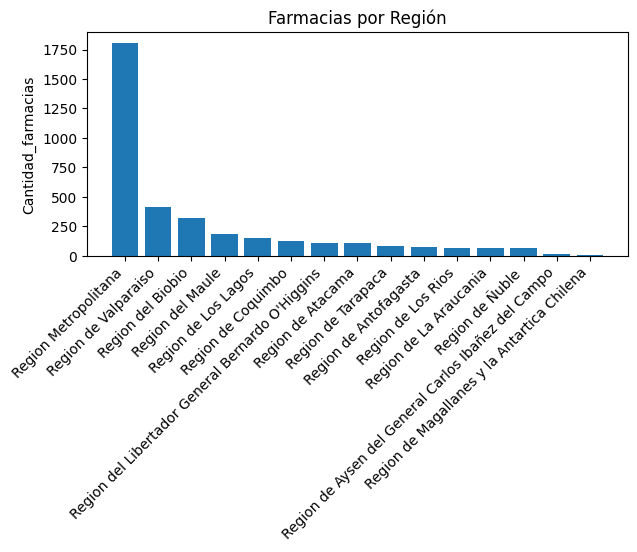

In [17]:
# Farmacias por region / pharmacy count per region

df_regionorderedgroup = df_regiongroup.sort_values(by='Cantidad_farmacias', ascending=False)
plt.bar(df_regionorderedgroup['Region'], df_regionorderedgroup['Cantidad_farmacias'])
plt.ylabel('Cantidad_farmacias')
plt.title('Farmacias por Región')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.471, right=0.97, top=0.936)
plt.show()

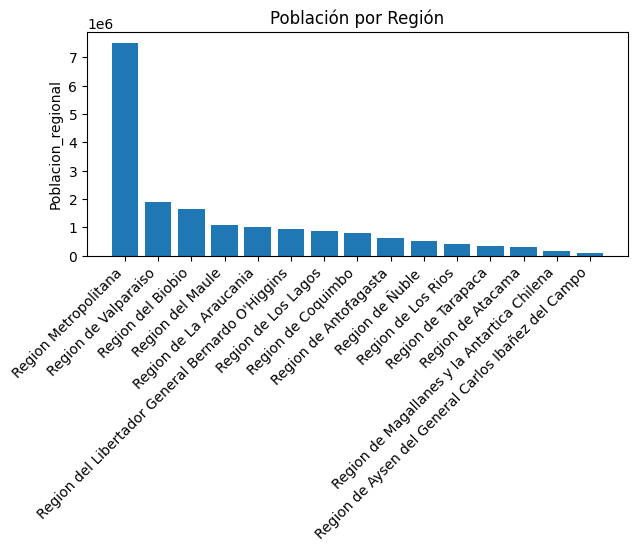

In [18]:
# Poblacion por region / population per region

df_regionorderedgroup = df_regiongroup.sort_values(by='Poblacion_regional', ascending=False)
plt.bar(df_regionorderedgroup['Region'], df_regionorderedgroup['Poblacion_regional'])
plt.ylabel('Poblacion_regional')
plt.title('Población por Región')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.471, right=0.97, top=0.936)
plt.show()

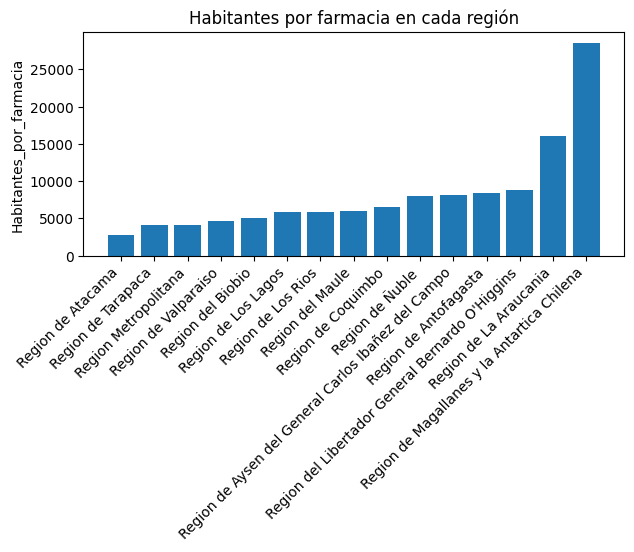

In [19]:
# Habitantes por farmacia (por region) / population per pharmacy (by region)

df_regionorderedgroup = df_regiongroup.sort_values(by='Habitantes_por_farmacia', ascending=True)
plt.bar(df_regionorderedgroup['Region'], df_regionorderedgroup['Habitantes_por_farmacia'])
plt.ylabel('Habitantes_por_farmacia')
plt.title('Habitantes por farmacia en cada región')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.471, right=0.97, top=0.936)
plt.show()


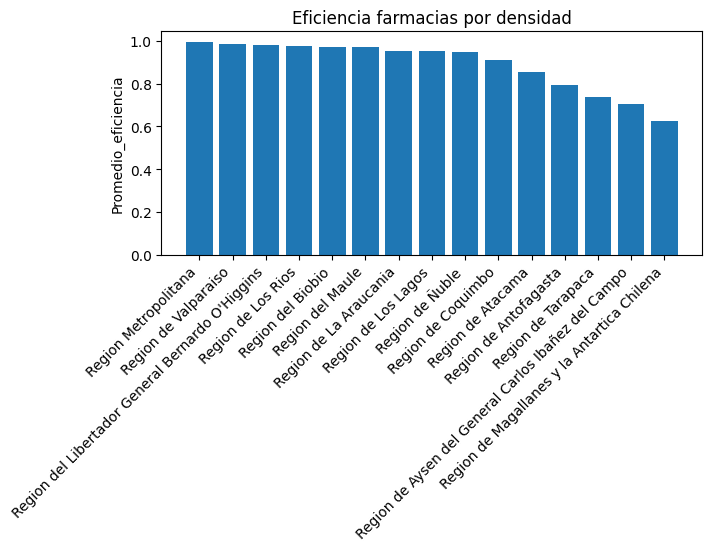

In [20]:
# Eficiencia de farmacias por densidad / pharmacy efficiency by density

df_regionorderedgroup = df_regiongroup.sort_values(by='Promedio_eficiencia', ascending=False)
plt.bar(df_regionorderedgroup['Region'], df_regionorderedgroup['Promedio_eficiencia'])
plt.ylabel('Promedio_eficiencia')
plt.title('Eficiencia farmacias por densidad')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.471, right=0.97, top=0.936)
plt.show()

**Analisis de dato por comuna  
Data analysis per commune**

In [21]:
#editar el df por comuna / edit the main df per commune

df_comunas = df_merged.drop(labels=['Region','Poblacion_regional'], axis=1)

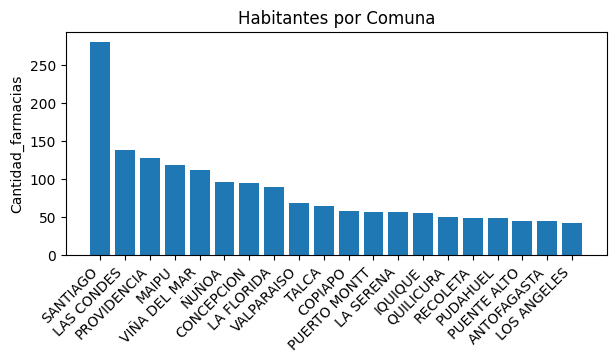

In [22]:
# habitantes por comuna / population count per commune

df_comunaordered = df_comunas.sort_values(by='Cantidad_farmacias', ascending=False).head(20)
plt.bar(df_comunaordered['Comuna'], df_comunaordered['Cantidad_farmacias'])
plt.ylabel('Cantidad_farmacias')
plt.title('Habitantes por Comuna')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.471, right=0.97, top=0.936)
plt.show()

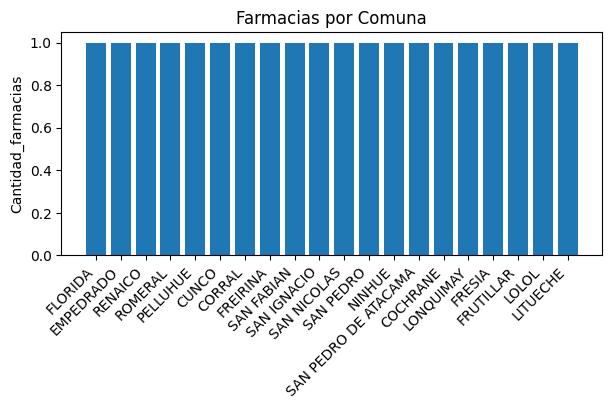

In [23]:
# Farmacias por comuna / pharmacies per commune

df_comunaordered = df_comunas.sort_values(by='Cantidad_farmacias', ascending=True).head(20)
plt.bar(df_comunaordered['Comuna'], df_comunaordered['Cantidad_farmacias'])
plt.ylabel('Cantidad_farmacias')
plt.title('Farmacias por Comuna')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.471, right=0.97, top=0.936)
plt.show()


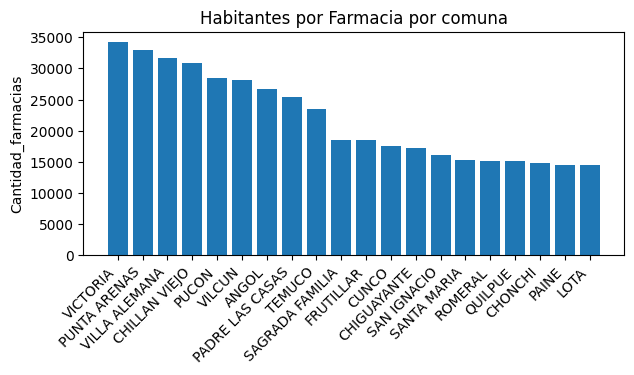

In [24]:
# Habitantes por farmacia descendente / population per pharmacies descendent

df_comunaordered = df_comunas.sort_values(by='Habitantes_por_farmacia', ascending=False).head(20)
plt.bar(df_comunaordered['Comuna'], df_comunaordered['Habitantes_por_farmacia'])
plt.ylabel('Cantidad_farmacias')
plt.title('Habitantes por Farmacia por comuna')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.471, right=0.97, top=0.936)
plt.show()

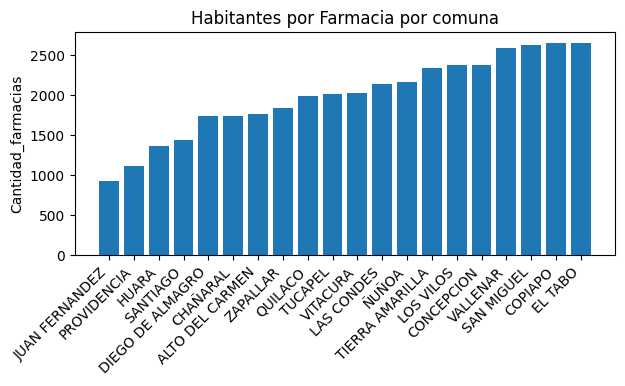

In [25]:
# Habitantes por farmacia ascendente / population per pharmacies ascendent

df_comunaordered = df_comunas.sort_values(by='Habitantes_por_farmacia', ascending=True).head(20)
plt.bar(df_comunaordered['Comuna'], df_comunaordered['Habitantes_por_farmacia'])
plt.ylabel('Cantidad_farmacias')
plt.title('Habitantes por Farmacia por comuna')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.471, right=0.97, top=0.936)
plt.show()

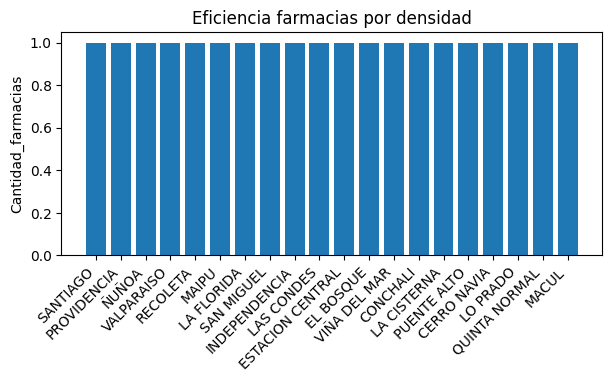

In [26]:
# Eficiencia de farmacias por densidad descendente / pharmacy efficiency per density descendent

df_comunaordered = df_comunas.sort_values(by='Eficiencia_farmacia/densidad', ascending=False).head(20)
plt.bar(df_comunaordered['Comuna'], df_comunaordered['Eficiencia_farmacia/densidad'])
plt.ylabel('Cantidad_farmacias')
plt.title('Eficiencia farmacias por densidad')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.471, right=0.97, top=0.936)
plt.show()


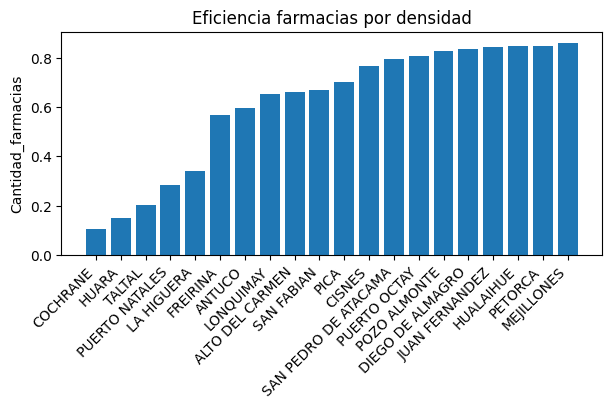

In [27]:
# Eficiencia de farmacias por densidad ascendente / pharmacy efficiency per density ascendent

df_comunaordered = df_comunas.sort_values(by='Eficiencia_farmacia/densidad', ascending=True).head(20)
plt.bar(df_comunaordered['Comuna'], df_comunaordered['Eficiencia_farmacia/densidad'])
plt.ylabel('Cantidad_farmacias')
plt.title('Eficiencia farmacias por densidad')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.471, right=0.97, top=0.936)
plt.show()